In [1]:
%cd "/home/albin/skolarbete/DML_LAsegmentation"

/home/albin/skolarbete/DML_LAsegmentation


In [2]:
from scripts.train import train, validate, patched_forward
from scripts.utils import CombinedLoss
from models.unet import UNet3D, NormalizationType
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from transformers import get_cosine_schedule_with_warmup
from scripts.dataset import TrainDataset, TestDataset

In [3]:
train_image_path = 'data/Task02_Heart/imagesTr'
train_label_path = 'data/Task02_Heart/labelsTr'
val_image_path = 'data/Task02_Heart/imagesVl'
val_label_path = 'data/Task02_Heart/labelsVl'

patch_size = (64, 128, 128)
train_dataset = TrainDataset(
    train_image_path, 
    train_label_path,
    patch_size, 
    require_target=0.5, 
    preload_all_images=True, 
    num_patches_per_image=1, 
    transform=None, 
    scale_intensity=True
)
val_dataset = TestDataset(val_image_path, val_label_path, scale_intensity=True)

batch_size = 3
# The effective batch size will be batch_size * num_patches_per_image
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [5]:
model = UNet3D(in_channels=1, out_channels=1, features=[32, 64, 128, 256], normalization=NormalizationType.GROUP_NORM)

epochs = 1000
validation_freq = 50

loss_fn = CombinedLoss(smooth=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
total_steps = len(train_loader) * 1000
num_warmup_steps = total_steps//20
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = train(model, optimizer, loss_fn, train_loader, val_loader, scheduler, device, epochs, patch_size=patch_size, validation_freq=validation_freq)

Starting training on device cuda...
Epoch 1 of 1000 took 3.09s | Training: loss=1.5721, iou=0.0832, dice=0.1515
Epoch 2 of 1000 took 2.78s | Training: loss=1.5649, iou=0.0830, dice=0.1515
Epoch 3 of 1000 took 2.79s | Training: loss=1.5478, iou=0.0919, dice=0.1667
Epoch 4 of 1000 took 2.77s | Training: loss=1.5319, iou=0.0823, dice=0.1493
Epoch 5 of 1000 took 2.73s | Training: loss=1.4734, iou=0.1179, dice=0.2104
Epoch 6 of 1000 took 2.74s | Training: loss=1.4369, iou=0.1632, dice=0.2782
Epoch 7 of 1000 took 2.76s | Training: loss=1.4165, iou=0.0697, dice=0.1286
Epoch 8 of 1000 took 2.76s | Training: loss=1.3688, iou=0.1008, dice=0.1806
Epoch 9 of 1000 took 2.79s | Training: loss=1.3517, iou=0.0368, dice=0.0700
Epoch 10 of 1000 took 2.82s | Training: loss=1.3461, iou=0.0633, dice=0.1135
Epoch 11 of 1000 took 2.83s | Training: loss=1.3133, iou=0.1179, dice=0.1873
Epoch 12 of 1000 took 2.91s | Training: loss=1.3193, iou=0.0568, dice=0.1044
Epoch 13 of 1000 took 2.83s | Training: loss=1.27

In [6]:
file_name = 'unet_model_results.pkl'

# Check if 'results' exists in the local scope
if 'results' in locals():
    # Unpack and save the model's state dict and results
    with open(file_name, 'wb') as f:
        pickle.dump({
            'model_state': results[0].state_dict(),  # best_model state dict
            'train_metrics': results[1],  # results_train
            'val_metrics': results[2]    # results_val
        }, f)
    print(f"Results and model saved to {file_name}")

else:
    # Load the results and model state from the file
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
        best_model = UNet3D(in_channels=1, out_channels=1, features=[32, 64, 128, 256])
        best_model.load_state_dict(data['model_state'])
        results = (best_model, data['train_metrics'], data['val_metrics'])
    print(f"Results and model loaded from {file_name}")

best_model, results_train, results_val = results

Results and model saved to unet_model_results.pkl


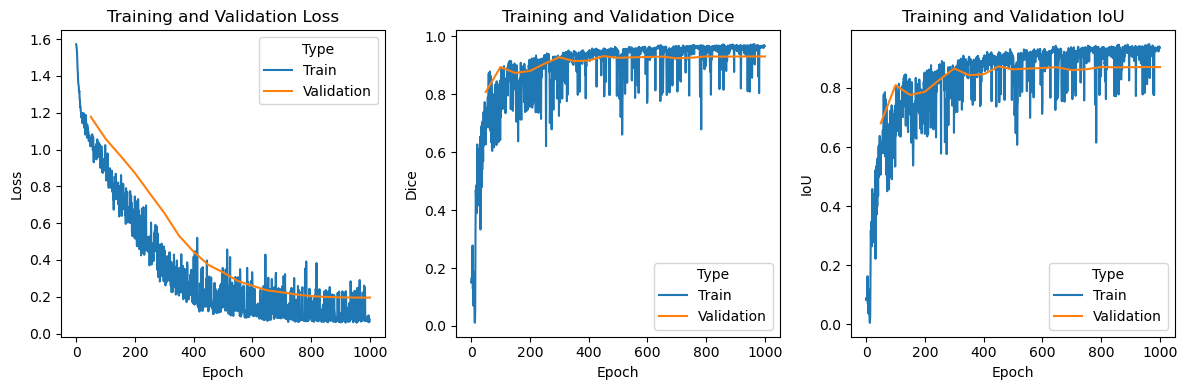

In [7]:
# Create DataFrames for easier plotting with Seaborn
df_train_loss = pd.DataFrame({'Epoch': range(len(results_train['loss'])), 'Value': results_train['loss'], 'Metric': 'Loss', 'Type': 'Train'})
df_val_loss = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['loss']))], 'Value': results_val['loss'], 'Metric': 'Loss', 'Type': 'Validation'})

df_train_dice = pd.DataFrame({'Epoch': range(len(results_train['dice'])), 'Value': results_train['dice'], 'Metric': 'Dice', 'Type': 'Train'})
df_val_dice = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['dice']))], 'Value': results_val['dice'], 'Metric': 'Dice', 'Type': 'Validation'})

df_train_iou = pd.DataFrame({'Epoch': range(len(results_train['iou'])), 'Value': results_train['iou'], 'Metric': 'IoU', 'Type': 'Train'})
df_val_iou = pd.DataFrame({'Epoch': [validation_freq * (1 + x) for x in range(len(results_val['iou']))], 'Value': results_val['iou'], 'Metric': 'IoU', 'Type': 'Validation'})

# Combine the DataFrames
df = pd.concat([df_train_loss, df_val_loss, df_train_dice, df_val_dice, df_train_iou, df_val_iou])

# Plot using Seaborn
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.lineplot(data=df[df['Metric'] == 'Loss'], x='Epoch', y='Value', hue='Type', ax=axs[0])
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

sns.lineplot(data=df[df['Metric'] == 'Dice'], x='Epoch', y='Value', hue='Type', ax=axs[1])
axs[1].set_title('Training and Validation Dice')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Dice')

sns.lineplot(data=df[df['Metric'] == 'IoU'], x='Epoch', y='Value', hue='Type', ax=axs[2])
axs[2].set_title('Training and Validation IoU')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('IoU')

plt.tight_layout()
plt.show()

In [8]:
image, label = val_dataset[0]
image = image.unsqueeze(0)
image = image.to(device)
with torch.no_grad():
    pred_logits = patched_forward(best_model, image, patch_size, 'cuda')
pred = torch.sigmoid(pred_logits)
pred = pred.squeeze(0, 1)
image = image.squeeze(0, 1)

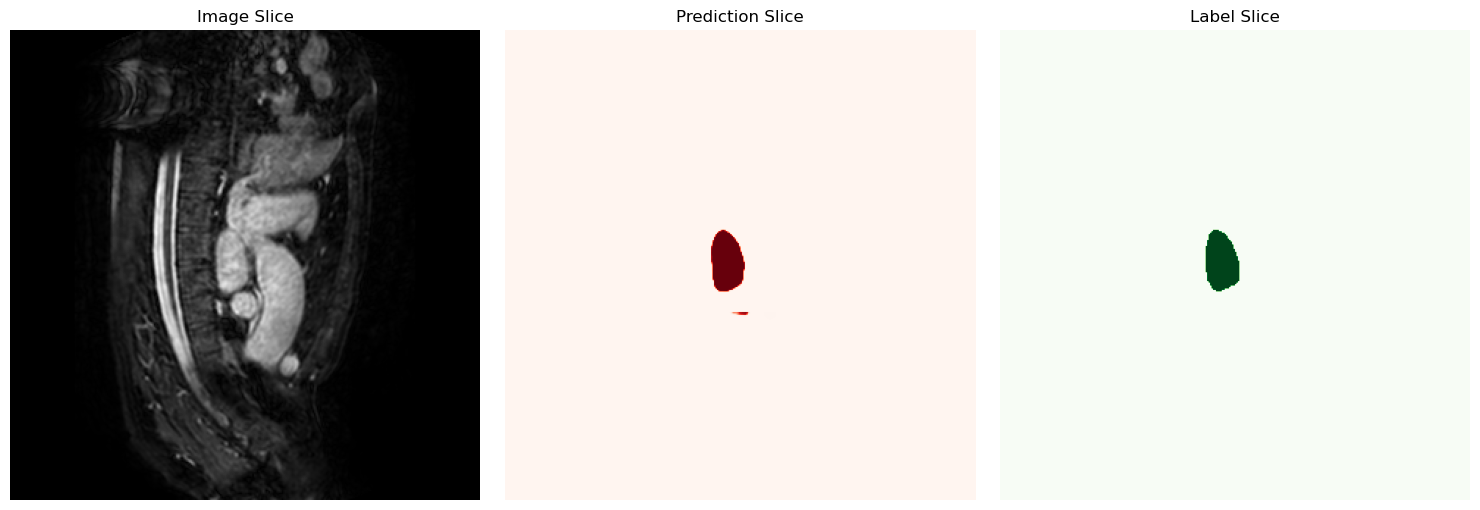

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Select the 50th slice along the first axis
slice_index = 80

image_slice = image[slice_index].cpu().numpy()
pred_slice = pred[slice_index].cpu().numpy()
label_slice = label[slice_index].cpu().numpy()

# Create the figure and the axes with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image slice
axs[0].imshow(image_slice, cmap='gray')
axs[0].set_title('Image Slice')
axs[0].axis('off')

# Plot the prediction slice
axs[1].imshow(pred_slice, vmin=0, vmax=1, cmap='Reds')
axs[1].set_title('Prediction Slice')
axs[1].axis('off')

# Plot the label slice
axs[2].imshow(label_slice, cmap='Greens')
axs[2].set_title('Label Slice')
axs[2].axis('off')

# Display the figure
plt.tight_layout()
plt.show()


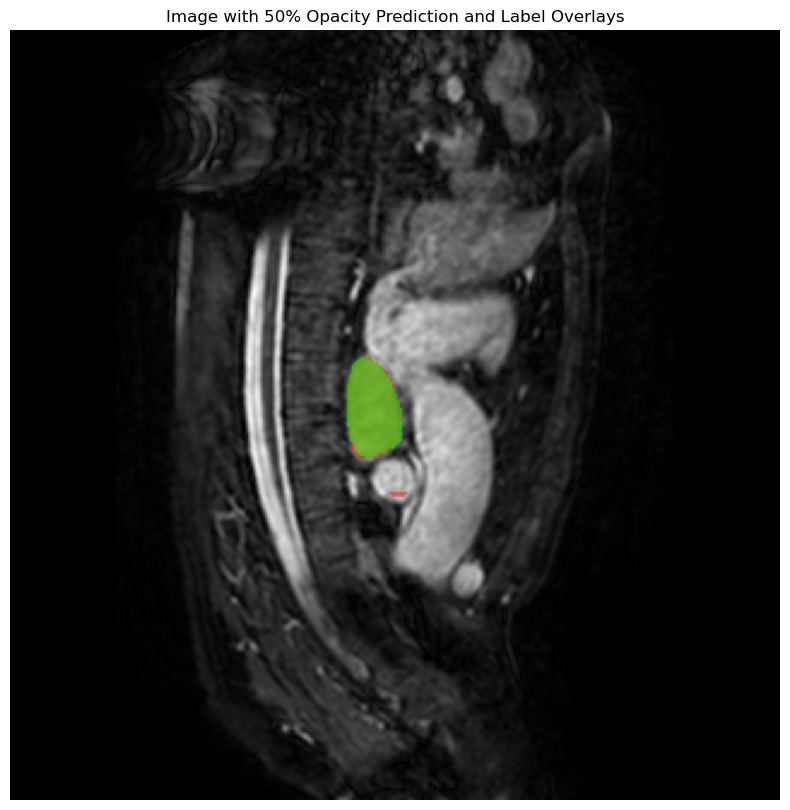

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Select the 50th slice along the first axis
slice_index = 80
image_slice = image[slice_index].cpu().numpy()
pred_slice = pred[slice_index].cpu().numpy()
label_slice = label[slice_index].cpu().numpy()

pred_slice = (pred_slice > 0.5).astype(np.float32)

# Normalize image slice for visualization (if needed)
image_slice = (image_slice - image_slice.min()) / (image_slice.max() - image_slice.min())

# Create an RGB image from the grayscale slice
image_rgb = np.stack([image_slice]*3, axis=-1)

# Create solid colors for the prediction and label overlays
red_overlay = np.zeros_like(image_rgb)
red_overlay[..., 0] = 1  # Red color for prediction

green_overlay = np.zeros_like(image_rgb)
green_overlay[..., 1] = 1  # Green color for label

# Create the prediction and label masks (expanding dims for compatibility)
pred_mask = np.expand_dims(pred_slice, axis=-1)
label_mask = np.expand_dims(label_slice, axis=-1)

# Set the opacity for the overlays (50% opacity)
opacity = 0.5

# Blend the solid color with the original image using the mask
# First, apply the red overlay for predictions
overlay_image = image_rgb * (1 - pred_mask * opacity) + red_overlay * pred_mask * opacity

# Then, apply the green overlay for labels
overlay_image = overlay_image * (1 - label_mask * opacity) + green_overlay * label_mask * opacity

# Plot the resulting image with the 50% opacity overlays
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title('Image with 50% Opacity Prediction and Label Overlays')
plt.axis('off')
plt.show()
